In [48]:
import serial

from time import sleep

PORT_NAME = "/dev/cu.usbserial-DA011F6D"

In [49]:
TOTAL_SCANS = 360 * 4

scans = []

with serial.Serial(PORT_NAME, 57600, timeout=10) as ser:
    print("Connecting...")
    sleep(1)
    
    ser.write(b'S')

    print("Starting scan")
    
    while (len(scans) < TOTAL_SCANS):
        payload = list(ser.read(size=4))
        pos = int.from_bytes(payload[:2], byteorder="big")
        dist = int.from_bytes(payload[2:], byteorder="big")
        
        scans.append((pos, dist))
        
    ser.write(b'.')
    sleep(1)
    ser.write(b'.')
    sleep(1)
    ser.write(b'.')

print("Finished %d scans" % len(scans))

Connecting...
Starting scan
Finished 1440 scans


In [52]:
scans_mm = []
sweeps = [[]]
last_pos = 0

# We should ideally analyze positions here to fill the gaps intelligently
for pos, dist in scans:
    if pos < last_pos:
        print("New sweep %d --> %d" % (last_pos, pos))
        sweeps.append([])
    
    sweeps[-1].append(dist * 10)
    
    last_pos = pos
    
print([len(s) for s in sweeps])

last_sweep = []

for sweep in sweeps:
    if len(sweep) >= 330:
        while len(sweep) < 345:
            sweep.append(0)
        
        scans_mm.append(sweep[:345])
    
    last_sweep = sweep

print("Got %d complete scans" % len(scans_mm))

New sweep 3551 --> 5
New sweep 3565 --> 9
New sweep 3560 --> 8
New sweep 3535 --> 10
[322, 332, 366, 346, 74]
Got 3 complete scans


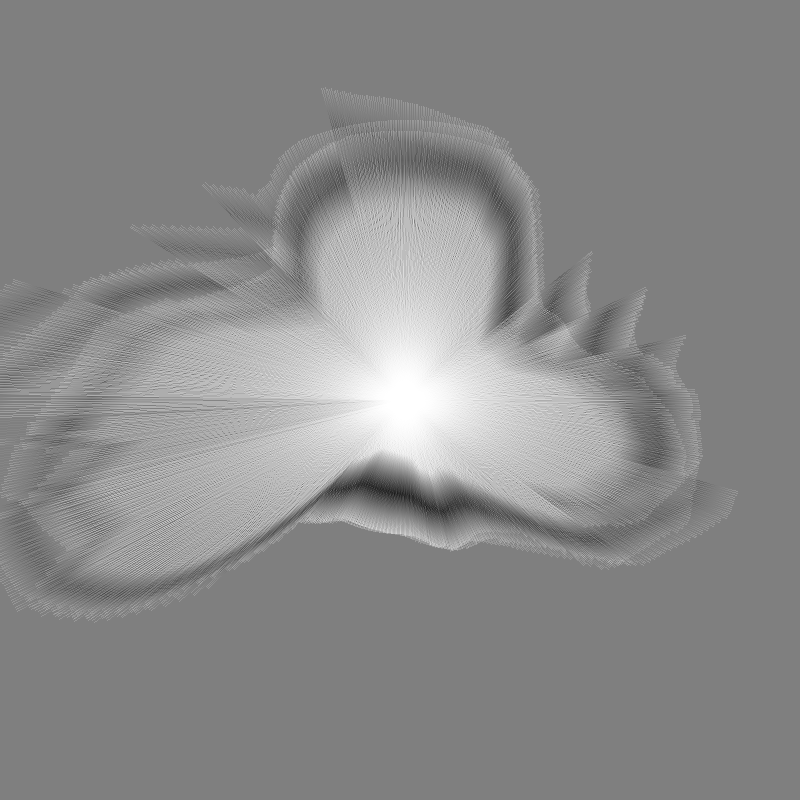

In [53]:
import io
import PIL.Image as Image
import IPython.display

MAP_SIZE_PIXELS = 800

from breezyslam.sensors import Laser
from breezyslam.algorithms import RMHC_SLAM

garmin = Laser(345, 4, 360, 4000)

slam = RMHC_SLAM(garmin, MAP_SIZE_PIXELS, 6)

for scan in scans_mm:
    slam.update(scan)

map_data = bytearray(MAP_SIZE_PIXELS * MAP_SIZE_PIXELS)

slam.getmap(map_data)

image = Image.frombuffer('L', (MAP_SIZE_PIXELS, MAP_SIZE_PIXELS), map_data, 'raw', 'L', 0, 1)

IPython.display.display(image)